# INDEX
* [Functions](#Functions)
* [Load datasets](#Load-datasets)
* [Configuration](#Configuration)
* [Preprocess training data](#Preprocess-training-data)
* [Train model](#Train-model)
* [Test model](#Test-model)
    * [Predict](#Predict)
    * [Translate predictions](#Translate-predictions)

# Prerequisites

* go to parent root folder of off-category-classification
* execute download.sh

# Functions

In [29]:
import sys
sys.path.append('../') #append a relative path to the top package to the search path

In [30]:
# %load libtrain.py
import datetime
import functools
import json
import pathlib
import shutil
import tempfile
from typing import Dict, List

import dacite
import pandas as pd
import tensorflow as tf
from robotoff.taxonomy import Taxonomy
from tensorflow import keras
from tensorflow.data import Dataset
from tensorflow.keras import callbacks
from tensorflow.python.ops import summary_ops_v2

import settings
from category_classification.data_utils import (
    create_tf_dataset
)
from category_classification.models import (
    KerasPreprocessing,
    to_serving_model,
)

from category_classification.config import Config

from utils.io import (
    copy_category_taxonomy,
    save_category_vocabulary,
    save_config,
    save_json,
)
from utils.metrics import evaluation_report


class TBCallback(callbacks.TensorBoard):
    """Get around a bug where you cannot use the TensorBoard callback with the StringLookup layers
    - https://github.com/tensorflow/tensorboard/issues/4530#issuecomment-783318292"""

    def _log_weights(self, epoch):
        with self._train_writer.as_default():
            with summary_ops_v2.always_record_summaries():
                for layer in self.model.layers:
                    for weight in layer.weights:
                        if hasattr(weight, "name"):
                            weight_name = weight.name.replace(":", "_")
                            summary_ops_v2.histogram(weight_name, weight, step=epoch)
                            if self.write_images:
                                self._log_weight_as_image(weight, weight_name, epoch)
                self._train_writer.flush()


def train(
    model: keras.Model,
    save_dir: pathlib.Path,
    config: Config,
    category_vocab: List[str]
):
    print("Starting training...")
    temporary_log_dir = pathlib.Path(tempfile.mkdtemp())
    print("Temporary log directory: {}".format(temporary_log_dir))

    # for now, clear cache on each call to train(), to be safe
    cache_dir = pathlib.Path("tf_cache")
    shutil.rmtree(cache_dir, ignore_errors=True)
    cache_dir.mkdir()
    print("Cache directory: {}".format(cache_dir))

    train = (
        create_tf_dataset("train", category_vocab, config.train_config.batch_size)
        .cache(str(cache_dir / "train"))
    )
    val = (
        create_tf_dataset("val", category_vocab, config.train_config.batch_size)
        .cache(str(cache_dir / "val"))
    )


    history=model.fit(
        train,
        epochs= config.train_config.epochs,
        validation_data=val,
        callbacks=[
            callbacks.TerminateOnNaN(),
            callbacks.ModelCheckpoint(
                filepath=str(save_dir / "weights.{epoch:02d}-{val_loss:.4f}"),
                monitor="val_loss",
                save_best_only=True,
                save_format='tf',
            ),
            #TBCallback(log_dir=str(temporary_log_dir), histogram_freq=1),
            callbacks.EarlyStopping(monitor="val_loss", patience=4),
            callbacks.CSVLogger(str(save_dir / "training.log")),
            callbacks.History()
        ],
    )
    print("Training ended")
    return history

## Function refactoring
overriden & refactored functions in order  to plug to new dataset and remodel with chosen features

In [31]:
# replacement of category_classification.models.construct_preprocessing
def _construct_preprocessing_vocab(df_col: pd.Series, min_count: int) -> List[str]:
    s = df_col.explode().value_counts()
    return s.where(s >= min_count).dropna().index.values

def construct_preprocessing(
    category_min_count: int,
    ingredients_min_count: int,
    max_product_name_tokens: int,
    max_product_name_length: int,
    train_df: pd.DataFrame,
) -> KerasPreprocessing:
    cat_vocab = _construct_preprocessing_vocab(
        train_df["categories_tags"], category_min_count
    )
    category_lookup = tf.keras.layers.StringLookup(
        vocabulary=cat_vocab, output_mode="multi_hot", num_oov_indices=0
    )

    product_name_preprocessing = tf.keras.layers.TextVectorization(
        split="whitespace",
        max_tokens=max_product_name_tokens,
        output_sequence_length=max_product_name_length,
    )
    product_name_preprocessing.adapt(train_df["product_name"], batch_size=50_000)

    ingredient_vocab = _construct_preprocessing_vocab(
        train_df["known_ingredient_tags"], ingredients_min_count
    )
    ingredient_preprocessing = tf.keras.layers.StringLookup(
        vocabulary=ingredient_vocab, output_mode="multi_hot"
    )

    return KerasPreprocessing(
        ingredient_preprocessing,
        product_name_preprocessing,
        category_lookup.get_vocabulary(),
    )

In [32]:
# replacement of category_classification.models.build_model

from category_classification.config import ModelConfig
from tensorflow.keras import layers

def build_model(config: ModelConfig, preprocessing: KerasPreprocessing) -> keras.Model:
    ingredient_input = keras.Input(shape=(None,), dtype=tf.string, name="ingredient")
    product_name_input = keras.Input(shape=(1,), dtype=tf.string, name="product_name")

    product_name_layer = preprocessing.product_name_preprocessing(product_name_input)

    product_name_embedding = layers.Embedding(
        input_dim=preprocessing.product_name_preprocessing.vocabulary_size(),
        output_dim=config.product_name_embedding_size,
        mask_zero=False,
    )(product_name_layer)

    product_name_lstm = layers.Bidirectional(
        layers.LSTM(
            units=config.product_name_lstm_units,
            recurrent_dropout=config.product_name_lstm_recurrent_dropout,
            dropout=config.product_name_lstm_dropout,
        )
    )(product_name_embedding)

    ingredient_layer = preprocessing.ingredient_preprocessing(ingredient_input)

    inputs = [ingredient_input, product_name_input]
    concat_input = [ingredient_layer, product_name_lstm]

    concat = layers.Concatenate()(concat_input)
    concat = layers.Dropout(config.hidden_dropout)(concat)
    hidden = layers.Dense(config.hidden_dim)(concat)
    hidden = layers.Dropout(config.hidden_dropout)(hidden)
    hidden = layers.Activation("relu")(hidden)
    output = layers.Dense(len(preprocessing.category_vocab), activation="sigmoid")(
        hidden
    )
    return keras.Model(inputs=inputs, outputs=[output])

def create_model(config: Config, preprocess: KerasPreprocessing) -> keras.Model:
    model = build_model(config.model_config, preprocess)
    loss_fn = keras.losses.BinaryCrossentropy(
        label_smoothing=config.train_config.label_smoothing
    )
    optimizer = keras.optimizers.Adam(learning_rate=config.train_config.lr)
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=["binary_accuracy", "Precision", "Recall"],
    )
    return model

# Load datasets

## New dataset

In [33]:
import settings

file_name = "predict_categories_dataset_products.jsonl"
input_file = settings.DATA_DIR / file_name
input_file

PosixPath('../data/predict_categories_dataset_products.jsonl')

In [34]:
%%time
import json

data = []
with open(input_file, 'r') as f_in:
    for line in f_in:
        try:
            data.append(json.loads(line)) #‘json.loads’ decode a json object into a dictionary
        except:
            continue    # ignore lines where json throws an error

df = pd.DataFrame(data)

CPU times: user 2min 39s, sys: 6min 4s, total: 8min 44s
Wall time: 11min 14s


In [35]:
df.shape

(801459, 263)

In [36]:
# filter nas values
dataset=df[df['product_name_en'].notna() & df['ingredients_original_tags'].notna()]

In [37]:
from sklearn.model_selection import train_test_split

training_ds, testing_ds=train_test_split(dataset,test_size=0.3,random_state = 49)

In [38]:
# add legacy columns from new dataset
training_ds['product_name']=training_ds['product_name_en']
training_ds['known_ingredient_tags']=training_ds['ingredients_original_tags']
testing_ds['product_name']=testing_ds['product_name_en']
testing_ds['known_ingredient_tags']=testing_ds['ingredients_original_tags']

In [39]:
training_ds.shape,testing_ds.shape

((84086, 264), (36038, 264))

# Configuration

In [40]:
# load config json
import json
 
# Opening JSON file
with open('../config.json') as json_file:
    json_config = json.load(json_file)
json_config 

config=dacite.from_dict(Config, json_config)
model_config=config.model_config

output_dir:pathlib.Path = pathlib.Path("../models")
replicates = 1

output_dir.mkdir(parents=True, exist_ok=True)

# Preprocess training data

In [41]:
%%time
keras_preprocess = construct_preprocessing(
    model_config.category_min_count,
    model_config.ingredient_min_count,
    model_config.product_name_max_tokens,
    model_config.product_name_max_length,
    training_ds,
)
print("Pre-processed training data")

Pre-processed training data
CPU times: user 1.22 s, sys: 3.65 s, total: 4.87 s
Wall time: 9.05 s


# Train model

In [ ]:
%%time
import json

if replicates == 1:
    save_dirs = [output_dir]
else:
    save_dirs = [output_dir / str(i) for i in range(replicates)]

for i, save_dir in enumerate(save_dirs):
    model = create_model(config, keras_preprocess)
    save_dir.mkdir(exist_ok=True)
    config.train_config.start_datetime = str(datetime.datetime.utcnow())
    print(f"Starting training repeat {i}")

    save_config(config, save_dir)
    copy_category_taxonomy(settings.CATEGORY_TAXONOMY_PATH, save_dir)
    save_category_vocabulary(keras_preprocess.category_vocab, save_dir)
    # Get the dictionary containing each metric and the loss for each epoch
    train(
        model,
        save_dir,
        config,
        keras_preprocess.category_vocab,
    )

    config.train_config.end_datetime = str(datetime.datetime.utcnow())
    save_config(config, save_dir)
    config.train_config.start_datetime = None
    config.train_config.end_datetime = None

In [42]:
log_data = pd.read_csv('../models/training.log', sep=',', engine='python')
log_data

,epoch,binary_accuracy,loss,precision,recall,val_binary_accuracy,val_loss,val_precision,val_recall
0,0,0.996083,0.017123,0.552017,0.197942,0.997419,0.009105,0.871768,0.428440
1,1,0.997707,0.007939,0.839386,0.539489,0.998235,0.005875,0.885257,0.650025
2,2,0.998116,0.006282,0.858141,0.643999,0.998425,0.005209,0.887893,0.701299
3,3,0.998262,0.005748,0.864807,0.679289,0.998510,0.004931,0.891045,0.721916
4,4,0.998339,0.005472,0.868557,0.697120,0.998555,0.004789,0.890122,0.735400
5,5,0.998395,0.005284,0.871513,0.709063,0.998583,0.004698,0.887969,0.745583
6,6,0.998427,0.005157,0.873423,0.716907,0.998604,0.004642,0.891197,0.748116
7,7,0.998455,0.005063,0.875013,0.722793,0.998619,0.004594,0.889758,0.753772
8,8,0.998477,0.004978,0.876299,0.727833,0.998630,0.004562,0.890442,0.756342
9,9,0.998493,0.004918,0.877410,0.731489,0.998637,0.004538,0.889774,0.758879


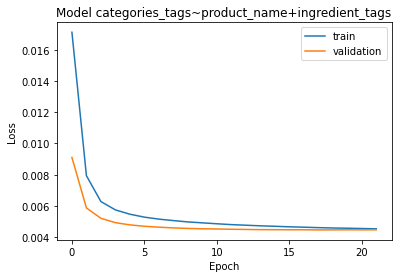

In [43]:
import matplotlib.pyplot as plt

plt.plot(log_data['epoch'],log_data['loss'])
plt.plot(log_data['epoch'],log_data['val_loss'])
plt.title('Model categories_tags~product_name+ingredient_tags')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train' , 'validation'] , loc = 'upper right')
plt.show()

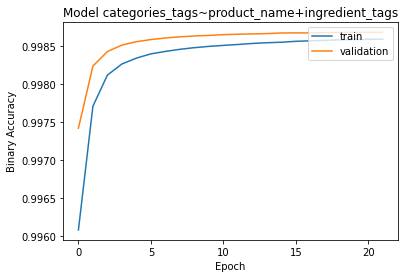

In [44]:
import matplotlib.pyplot as plt

plt.plot(log_data['epoch'],log_data['binary_accuracy'])
plt.plot(log_data['epoch'],log_data['val_binary_accuracy'])
plt.title('Model categories_tags~product_name+ingredient_tags')
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend(['train' , 'validation'] , loc = 'upper right')
plt.show()

# Test model

In [45]:
# load saved model
model=keras.models.load_model('../models/base/saved_model')

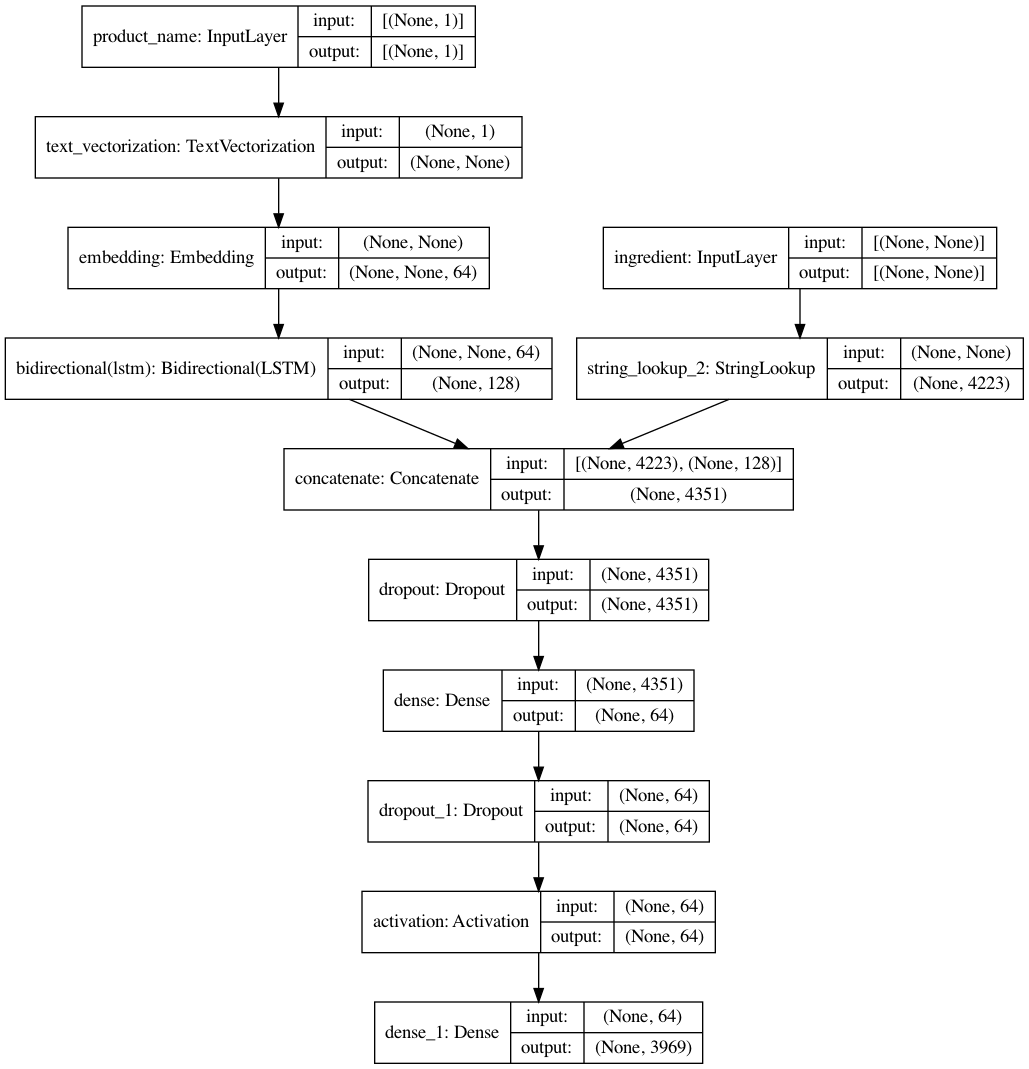

In [46]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [47]:
# create train, validation, test datasets
category_vocab = keras_preprocess.category_vocab
batch_size = config.train_config.batch_size

In [48]:
# Train & validation Dataset => investigate on characteristics of the source
valdata = create_tf_dataset("val", category_vocab, batch_size)
testdata = create_tf_dataset("test", category_vocab, batch_size)

In [49]:
# categories count
len(category_vocab)

1137

## Predict

In [50]:
%%time
y_pred_test = model.predict(testdata)

CPU times: user 48.4 s, sys: 18 s, total: 1min 6s
Wall time: 19.5 s


In [51]:
y_pred_test.shape

(87319, 3969)

In [52]:
y_pred_test

array([[1.1422783e-02, 2.9106607e-08, 1.8616578e-06, ..., 1.3573744e-10,
        1.6678333e-09, 1.1400034e-07],
       [1.9434567e-05, 6.0262022e-09, 4.3250511e-06, ..., 9.5710753e-18,
        1.8540440e-14, 8.8534751e-13],
       [9.8198652e-04, 5.3054283e-10, 1.0436243e-08, ..., 1.4927385e-14,
        1.0176477e-12, 1.2061078e-12],
       ...,
       [7.5667924e-01, 1.3700799e-11, 2.1688192e-12, ..., 2.8258068e-18,
        2.3219839e-16, 3.5128806e-13],
       [2.4676323e-04, 4.8964339e-14, 6.0147217e-12, ..., 1.8756643e-16,
        2.5486165e-15, 1.1011587e-15],
       [1.1568367e-03, 1.1596524e-05, 5.4461787e-05, ..., 1.3919157e-11,
        2.4204746e-13, 6.0214539e-10]], dtype=float32)

In [53]:
category_vocab

['en:plant-based-foods-and-beverages',
 'en:plant-based-foods',
 'en:snacks',
 'en:sweet-snacks',
 'en:beverages',
 'en:cereals-and-potatoes',
 'en:groceries',
 'en:dairies',
 'en:biscuits-and-cakes',
 'en:fruits-and-vegetables-based-foods',
 'en:sauces',
 'en:frozen-foods',
 'en:confectioneries',
 'en:cereals-and-their-products',
 'en:fermented-foods',
 'en:fermented-milk-products',
 'en:meals',
 'en:meats',
 'en:vegetables-based-foods',
 'en:plant-based-beverages',
 'en:canned-foods',
 'en:cheeses',
 'en:desserts',
 'en:biscuits',
 'en:spreads',
 'en:cocoa-and-its-products',
 'en:breakfasts',
 'en:breads',
 'en:frozen-desserts',
 'en:condiments',
 'en:canned-plant-based-foods',
 'en:prepared-meats',
 'en:cakes',
 'en:seafood',
 'en:fruits-based-foods',
 'en:fats',
 'en:chocolate-candies',
 'en:legumes-and-their-products',
 'en:sweet-spreads',
 'en:salty-snacks',
 'en:plant-based-spreads',
 'en:yogurts',
 'en:pastas',
 'en:carbonated-drinks',
 'en:appetizers',
 'en:salted-snacks',
 'e

## Translate predictions

In [ ]:
import numpy as np

data=y_pred_test
NUMBER_OF_CATEGORIES = 4

values=np.partition(data,-NUMBER_OF_CATEGORIES) #top n probability values for each row
indices=np.argpartition(data,-NUMBER_OF_CATEGORIES) #top n probability values indices for each row

In [ ]:
val=values[:,-NUMBER_OF_CATEGORIES:] # filter n first values for each row
ind=indices[:,-NUMBER_OF_CATEGORIES:] # filter n first values indices for each row

In [ ]:
dfPredictions=(pd.DataFrame(ind).applymap(lambda x:category_vocab[x])+": "+pd.DataFrame(np.round(val*100,2)).astype(str)+" %").reset_index()

In [ ]:
# make dictionary from validation dataframe to get code ande product_name
dict_val=val_ds[['code','product_name']].to_dict()

In [ ]:
dfPredictions['product_name']=dfPredictions['index'].apply(lambda x:dict_val['product_name'][x])
dfPredictions['code']=dfPredictions['index'].apply(lambda x:dict_val['code'][x])
dfPredictions=dfPredictions.drop(columns=["index"])

In [ ]:
dfPredictions